# Market selection by using portfolio theory

In [313]:

import os,sys,matplotlib,pandas,numpy,scipy,dateutil
import pandas as pd
import numpy as np
from pylab import *
from datetime import datetime, timedelta
import time
from statsmodels.distributions.empirical_distribution import ECDF
import sqlite3
import itertools, random
import pickle
conn = None
use_database = False

## Reading price data.
Markets (also called instances in some parts of the code) are represented as dictionaries.
We define functions for converting them to appropriate database strings if required. 

In [383]:
markets = [ {'type': 'g2.2xlarge', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'c3.xlarge', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'r3.large', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'm3.medium', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'd2.8xlarge', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
            {'type': 'g2.2xlarge', 'region': 'us-east-1', 'AZ': 'b', 'OS': 'Linux'} ,
                     {'type': 'c3.xlarge', 'region': 'us-east-1', 'AZ': 'b', 'OS': 'Linux'} ,
                     {'type': 'r3.large', 'region': 'us-east-1', 'AZ': 'b', 'OS': 'Linux'} ,
                     {'type': 'm3.medium', 'region': 'us-east-1', 'AZ': 'b', 'OS': 'Linux'} ,
                     {'type': 'd2.8xlarge', 'region': 'us-east-1', 'AZ': 'b', 'OS': 'Linux'},
            {'type': 'g2.2xlarge', 'region': 'us-east-1', 'AZ': 'e', 'OS': 'Linux'} ,
                     {'type': 'c3.xlarge', 'region': 'us-east-1', 'AZ': 'e', 'OS': 'Linux'} ,
                     {'type': 'r3.large', 'region': 'us-east-1', 'AZ': 'e', 'OS': 'Linux'} ,
                     {'type': 'm3.medium', 'region': 'us-east-1', 'AZ': 'e', 'OS': 'Linux'} ,
                     {'type': 'd2.8xlarge', 'region': 'us-east-1', 'AZ': 'e', 'OS': 'Linux'}
           
                     ]

In [384]:
def instance_to_MarketId(i) :
    """ The database table names or the file names  """
    osname = {'Linux':'Linux/UNIX'}
    return i['region']+i['AZ']+'-'+osname[i['OS']]+'-'+i['type']

def instance_to_ondemstring(i) :
    """ On-demand prices table uses slightly different names for instances, aargh.
        us-east-1-Linux-c3.xlarge 
    """
    ondem_mktstring =  i['region']+'-'+ i['OS']+'-'+i['type']
    return ondem_mktstring

def instance_string(i):
    return i['region']+i['AZ']+'-'+ i['OS']+'-'+i['type']

In [385]:
#Test the instance string functions
str(instance_string(markets[0]))

'us-east-1a-Linux-g2.2xlarge'

In [386]:
def init_db_connection() :
    global conn
    global use_database
    if use_database:
        conn = sqlite3.connect('/home/prateeks/spot_prices_2015/aws.db')
    return 

init_db_connection();


In [387]:
def read_data_sqlite(instance , mktstring=None, months=['201503','201504','201505','201506','201507','201508'],pickle_data=True):
    """ Get the spot AND on-demand prices for a given instance over the months specified. 
        These 6 months are chosen to maximixe the data density, since other months have larger periods of missing data
    """
    global conn
    table_name_base='AKIAJXNAQH5WHJFPNCXA_' # '201503'
    if mktstring == None:
        mktstring = instance_to_MarketId(instance)
    output=[]
    ondem=[]
    ondemtable = 'on_demand_price'
    #Need to remove avail zone from mkt string argh!
   #TODO: function for converting to the on-demand string 
    ondem_mktstring = instance_to_ondemstring(instance)

    q2 = 'SELECT SpotPrice FROM {} WHERE MarketId=\'{}\' ;'.format(ondemtable, ondem_mktstring)
    d2 = conn.execute(q2)
    ondem = d2.fetchall()
    print instance, "ONDEM PRICE ", ondem, ondem_mktstring
    
    for month in months :
        table_name = table_name_base+month
        query='SELECT Timestamp, SpotPrice FROM {} WHERE MarketId=\'{}\' ;'.format(table_name, mktstring)
        #print query
        d = conn.execute(query)
        output.extend(d.fetchall())
    if pickle_data is True :
        fname = instance_string(instance)+'.pickle'
        with open(fname, 'w') as f :
            pickle.dump((instance, output, ondem[0][0]), f)
    return output, ondem[0][0]


In [388]:
def get_spot_data(markets, from_pickle=False):
    """
    Markets is a list of market/instance objects. 
    Return [(mkt,on-demprice,[(t,spot-price)])]
    """
    global conn
    data = []
    
    if from_pickle is False:
        init_db_connection()
        #c3.xlarge seems volatile
        for i in markets :
            ts, ondem = read_data_sqlite(i)
            spot = [(time.mktime(dateutil.parser.parse(t).timetuple()), float(f)) for (t,f) in ts]
            nspot = np.array(spot)
            data.append((i, float(ondem), nspot))
    else : 
        #Read all the pickle files from the directory and call get_pickled_data
        for file in os.listdir('.'):
            if file.endswith(".pickle") :
                with open(file,'r') as f:
                    (i, ts, ondem) = get_picked_data(f)
                    spot = [(time.mktime(dateutil.parser.parse(t).timetuple()), float(f)) for (t,f) in ts]
                    nspot = np.array(spot)
                    data.append((i, float(ondem), nspot))

    return data


In [389]:
def get_picked_data(f):
    """ Get pickled data from a file instead of the database. 
        Return (instance, ts, ondem) tuple. """
    (instance, ts, ondem) = pickle.load(f)
    return (instance, ts, ondem)
    

## Data processing
After getting spot price and on-demand price data from either the pickled objects or the database, we do some post-processing of the prices.




In [390]:
data = get_spot_data(markets, from_pickle=True)

In [391]:
def get_prices_only(d, normalized=False, interpolate=False):
    """ For a given 3-tuple, return an array of prices. Strip the timestamps
    """
    ondem_price = d[1]
    spot_prices = d[2][:,1]
    if interpolate :
        spot_prices = interpolate_prices(d)
    if normalized:
        return spot_prices/ondem_price  #time, price
    else :
        return spot_prices
    
#normalized_price(data[0])

In [392]:
def interpolate_prices(d, duration='5min'):
    """ Large gaps exist in many traces. Do some interpolation to obtain a uniform trace
    """
    spot_prices = d[2][:,1]
    timestamps = d[2][:,0]
    tdindex = pd.to_datetime(timestamps, unit='s') #Unit=s makes it parse the unix timestamps
    ms = pd.Series(spot_prices, index=tdindex)
    mdf = pd.DataFrame(ms,columns=["price"])
    
    mdf = mdf.resample(duration,fill_method='pad')
    return mdf['price']

In [393]:
def bid_transform(d,interpolate=False):
    """Given a bid, execute some transformation over the prices."""
    ondem_price = d[1]
    spot_prices = d[2][:,1]
    if interpolate:
        spot_prices = interpolate_prices(d)
    
    maxprice = 10*ondem_price
    bid = ondem_price 
    spot_prices[spot_prices >= bid] = maxprice #Amplify the price spike
    spot_prices = maxprice - spot_prices  #Price => Profits transformation
    #Not sure we want to normalize this to the on-demand price? Hmm...
    #Normalizing by 10*on-demand price yields returns which are monotonically *DECREASING* with risk
    #We want increasing returns with increasing risk, so turn off the normalization
    return spot_prices
    


In [394]:
def get_transformed_prices(d, interpolate=True, transform="bid"):
    td = [] #List of transformed prices
    instances = []

    for di in d:
        if transform=="bid":
            td.append(bid_transform(di,interpolate))
        elif transform=="plain":
            td.append(get_prices_only(di,interpolate))
        instances.append(di[0])
    min_length = min([len(a) for a in td])

    return (instances, np.vstack([a[:min_length] for a in td]) )


In [395]:
(instances, dt) = get_transformed_prices(data, transform="bid")
import scipy.stats

In [396]:
scipy.stats.describe(data[2][2][:,1])

DescribeResult(nobs=48994, minmax=(0.032099999999999997, 2.1000000000000001), mean=0.15087856880434339, variance=0.076725969678061057, skewness=2.575952995737853, kurtosis=5.251621313270782)

## Portfolio construction starts here
So far we have read in the spot prices, applied the transforms, and computed the covariance matrix. Now its time for the actual portfolio creation.


In [397]:
import cvxopt as opt
from cvxopt import blas, solvers
%matplotlib inline

In [398]:
solvers.options['show_progress'] = False

In [399]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

In [400]:
num_mkts = len(instances)

Now determine on which markets we want to run the portfolio analysis. By default, we do it on ALL the markets we just read data about

In [401]:
#dt=dt[3:10]
dt=dt

In [402]:
def eval_portfolio(dt):
    p = np.asmatrix(np.mean(dt,axis=1))
    w = np.asmatrix(rand_weights(dt.shape[0]))
    C = np.asmatrix(np.cov(dt))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    print mu, sigma
    
    return mu, sigma

In [403]:
def eval_n_portfolios(dt, n_portfolios=250):
    n_portfolios = 250
    return np.column_stack([
        eval_portfolio(dt) 
        for _ in xrange(n_portfolios)
        ])


In [404]:
means, stds = eval_n_portfolios(dt)

[[ 14.18818446]] [[ 2.81186779]]
[[ 11.81812271]] [[ 1.84617529]]
[[ 8.77851569]] [[ 1.26002906]]
[[ 9.93576803]] [[ 1.48289414]]
[[ 13.28441435]] [[ 2.07398931]]
[[ 9.28230022]] [[ 1.26562743]]
[[ 18.32050387]] [[ 2.85450659]]
[[ 13.44686094]] [[ 2.19845699]]
[[ 14.89241788]] [[ 2.53119941]]
[[ 14.38432573]] [[ 2.66389427]]
[[ 14.90567432]] [[ 2.59596141]]
[[ 17.32348358]] [[ 2.91493335]]
[[ 9.59819397]] [[ 1.28197491]]
[[ 11.35014449]] [[ 2.23747511]]
[[ 14.00636692]] [[ 2.44904136]]
[[ 10.2900263]] [[ 1.84875762]]
[[ 12.98372984]] [[ 1.91109805]]
[[ 13.87993787]] [[ 2.26919431]]
[[ 8.0496691]] [[ 1.89688749]]
[[ 9.82429266]] [[ 2.12690505]]
[[ 14.37450118]] [[ 2.4024194]]
[[ 12.81369177]] [[ 3.14974828]]
[[ 15.50805439]] [[ 2.74957705]]
[[ 8.27789103]] [[ 1.41280252]]
[[ 13.9501206]] [[ 2.54351848]]
[[ 12.79471494]] [[ 2.5852711]]
[[ 11.88812814]] [[ 1.72515956]]
[[ 6.16864463]] [[ 0.76444584]]
[[ 9.91651397]] [[ 1.60175588]]
[[ 7.57276841]] [[ 1.06044341]]
[[ 12.03261699]] [[ 2.036

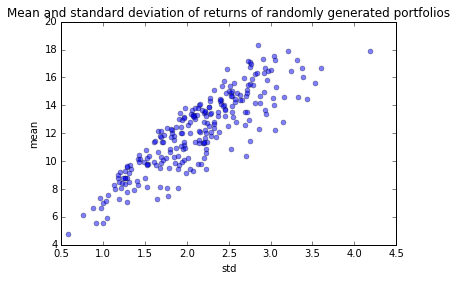

In [405]:
plt.plot(stds, means, 'o', markersize=5, alpha=0.5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')


In [406]:
def optimal_portfolio(returns):
    n = len(returns)
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    N = 10
    mus = [5.8**(5.0 * t/N - 1.0) for t in range(N)]
    #mus = [0.05+(0.05*t) for t in range(150)]
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    #returns = np.asmatrix(returns)   
    returns = opt.matrix(returns)
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    print "S, Covariance: ", S.size, S
    print "Returns: ", returns.size
    print "pbar: ", pbar.size, pbar.T
    print "G: ", G.size
    print "h: ", h.size
    print "A: ", A.size
    print "b: ", b.size
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios=[]
    for mu in mus:
        try:
            result = solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
            #Result is presumably the weights for a given mu
            portfolios.append(result)
        except :
            print "BAD MU ", mu
            pass
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    gradients = np.gradient(returns)
    print "mu, grad, r, risk, portfolios"
    for p,mu,r,grad, risk in zip(portfolios,mus,returns,gradients,risks):
        s = np.array(p.T)[0]
        s[s<0.01]=0.0
        s=s[s != 0.0]
        s = np.array_str(s, precision=2)
        
        print "%0.2f %0.2f %0.2f %0.2f" % (mu,grad, r, risk)
        print s
    print "POLYNOMIAL ", m1
    mu_star = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = np.zeros(n)
    try:
        wt = solvers.qp(opt.matrix(mu_star * S), -pbar, G, h, A, b)['x']
    except:
        print "NOT ABLE TO CALCULATE OPTIMUM WEIGHTS"
    return np.asarray(wt), returns, risks

In [407]:
weights, returns, risks = optimal_portfolio(dt)

S, Covariance:  (15, 15) [ 7.57e-01  1.57e-04  5.95e-03  5.26e-02  4.36e-01 -2.70e-01 -6.44e-04 ... ]
[ 1.57e-04  1.72e-06 -3.45e-04 -6.31e-05  1.60e-03  2.65e-03 -5.62e-06 ... ]
[ 5.95e-03 -3.45e-04  7.80e-01  1.33e-01 -3.16e-01 -1.27e+00  5.19e-02 ... ]
[ 5.26e-02 -6.31e-05  1.33e-01  4.03e-01 -5.12e-03 -9.15e-01  9.05e-02 ... ]
[ 4.36e-01  1.60e-03 -3.16e-01 -5.12e-03  4.44e+00  1.06e+01 -6.08e-02 ... ]
[-2.70e-01  2.65e-03 -1.27e+00 -9.15e-01  1.06e+01  3.22e+02 -8.65e-01 ... ]
[-6.44e-04 -5.62e-06  5.19e-02  9.05e-02 -6.08e-02 -8.65e-01  2.47e-01 ... ]
[-2.32e-02 -3.41e-04  1.19e-01  3.52e-02 -2.74e-01 -3.82e-02  2.47e-02 ... ]
[ 1.14e-02  8.62e-06 -1.05e-02  9.73e-02  8.20e-02 -2.35e-01  3.78e-02 ... ]
[-2.00e-03 -7.17e-05  4.34e-02 -1.26e-02 -3.52e-02  3.72e-01 -7.44e-03 ... ]
[-1.95e-01 -1.33e-03  3.08e-01  6.94e-01 -3.85e-02  6.18e+00  8.97e-01 ... ]
[ 1.62e-03 -7.59e-06  9.78e-03 -5.15e-04 -2.08e-03  1.74e-01 -3.75e-04 ... ]
[-2.59e-02 -3.28e-04  1.16e-01  3.96e-02 -2.79e-01 

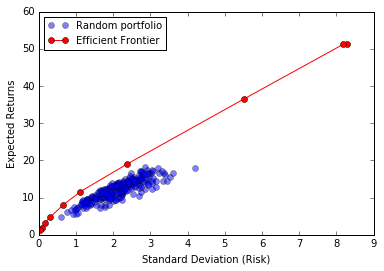

In [414]:
plt.plot(stds, means, 'o',alpha=0.5,label="Random portfolio")
plt.ylabel('Expected Returns')
plt.xlabel('Standard Deviation (Risk)')
plt.plot(risks, returns, 'r-o',label="Efficient Frontier")
plt.legend(loc='best')
plt.savefig("15mkts.pdf")

In [409]:
gf=np.array

In [12]:
def my_covariance(x,y):
    """
    This yields similiar results to
    pd.Series(x).cov(pd.Series(y)) """
    xbar = x.mean()
    ybar = y.mean()
    x = x-xbar
    y = y-ybar
    n = min(x.shape[0], y.shape[0])
    x = x[:n-1]
    y = y[:n-1]
    cov = (x*y)
    cov = np.sum(cov)/(n-1)
    print cov
    return cov


In [114]:
print dt

[[ -6.4348  -6.435   -6.4349 ...,  -6.4347  -6.4351  -6.4354]
 [ -2.0676  -2.0679  -2.0676 ...,  -2.0679  -2.0654  -2.0679]
 [ -1.7281   0.      -1.733  ...,  -1.7318  -1.7313  -1.7331]
 [-54.64   -54.6365 -54.6361 ..., -54.6354 -54.6348 -54.6354]
 [  0.       0.       0.     ...,  -0.653   -0.653   -0.653 ]]


In [13]:
my_covariance(x,y)

-8.02333628098e-05


-8.0233362809846391e-05

In [14]:
pd.Series(x).cov(pd.Series(y))

-8.0003161504696132e-05

In [16]:

d0=data[0]
d1=data[1]
print d0

({'OS': 'Linux', 'region': 'us-east-1', 'AZ': 'a', 'type': 'g2.2xlarge'}, 0.65, array([[  1.42611080e+09,   6.52000000e-02],
       [  1.42611117e+09,   6.50000000e-02],
       [  1.42611153e+09,   6.51000000e-02],
       ..., 
       [  1.44108320e+09,   1.25300000e-01],
       [  1.44108337e+09,   1.18500000e-01],
       [  1.44108353e+09,   1.14200000e-01]]))


In [17]:
s0 = pd.Series(d0[2][:,1], index=d0[2][:,0])